In [57]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [58]:
data = pd.read_csv("train.csv")

In [59]:
print(data.shape)
data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [60]:
(data.isnull().sum()/data.shape[0])>0.50

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
dtype: bool

In [61]:
for i,j in zip(data.columns,data.isnull().sum()/data.shape[0]>0.50):
    if(j==True):
        print(i," has been dropped")
        data=data.drop(str(i),axis=1)

Cabin  has been dropped


In [62]:
#These columns appear to be null
#Later implement the datatype matching using regex because int32,64,128 as well as float stuff
alter_list=[]
for i,j in zip(data.columns,data.isnull().sum()):
    if(j>0):
        if(data[i].dtypes == "float64" or data[i].dtypes == "int64"):
            data_type="Numeric"
        elif(data[i].dtypes == "object"):
            data_type="String"
        else:
            data_type=""
        print(i,j," Data type being : ",data_type)
        alter_list.append((i,data_type))

Age 177  Data type being :  Numeric
Embarked 2  Data type being :  String


In [63]:
# data['Age'] = data['Age'].fillna(data['Age'].mean())
# data['Embarked'] = data['Embarked'].fillna('S')
for i in alter_list:
    if i[1] == "Numeric":
        data[i[0]] = data[i[0]].fillna(data[i[0]].mean())
    elif i[1]=="String":
        print("Unique values in the column",i[0],data[i[0]].unique())
        print("Number of unique vlaues in column",i[0], data[i[0]].nunique())
        print("Number of each unique value occurances made in column",i[0]+":\n",data[i[0]].value_counts(dropna=False))
        import math
        toleration_limit = math.floor(data.shape[0]*0.1)
        if data[i[0]].nunique()>toleration_limit:
            data = data.drop(i[0],axis=1)
        else:
            maxm_occ = data[i[0]].value_counts(dropna=False)[:1].index.tolist()
            print(maxm_occ[0])
            data[i[0]].fillna(maxm_occ[0])

Unique values in the column Embarked ['S' 'C' 'Q' nan]
Number of unique vlaues in column Embarked 3
Number of each unique value occurances made in column Embarked:
 S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64
S


In [64]:
# data = data.drop(['Name', 'Ticket', 'Fare', 'PassengerId'], axis=1)
print("Analysing Unique Values in a columns as columns with more unique values are likely not to contribute")
for i in data.columns:
        print("Analysing Column",i)
        no_uniq = data[i].nunique()
        print(data.shape[0])
        print(no_uniq/data.shape[0])
        if(no_uniq/data.shape[0]>0.1):
            data = data.drop(str(i),axis=1)
        else:
            print("no uniq before",no_uniq)
            print("target_col",data[i])
            if (no_uniq>(data.shape[0]*(0.1))):
                data[i] = pd.cut(x=data[i],bins=math.ceil(math.sqrt(no_uniq)),labels=False)
                info_bins = pd.cut(x=data[i],bins=math.ceil(math.sqrt(no_uniq)))
                print("info_bins",info_bins)
                print("nuniq",data[i].nunique())
            print(no_uniq)
        

Analysing Unique Values in a columns as columns with more unique values are likely not to contribute
Analysing Column PassengerId
891
1.0
Analysing Column Survived
891
0.002244668911335578
no uniq before 2
target_col 0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64
2
Analysing Column Pclass
891
0.003367003367003367
no uniq before 3
target_col 0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: int64
3
Analysing Column Name
891
1.0
Analysing Column Sex
891
0.002244668911335578
no uniq before 2
target_col 0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object
2
Analysing Column Age
891
0.09988776655443322
no uniq before 89
target_col 0      22.000000
1      38.000000
2      26.000000

In [65]:
target_column = "Pclass"
le = preprocessing.LabelEncoder()
data[target_column] = le.fit_transform(data[target_column])
X= pd.get_dummies(data.drop(target_column,1))
y=data[target_column]
data = pd.get_dummies(data)
print(data.head())
data.isnull().sum()
X

   Survived  Pclass   Age  SibSp  Parch  Sex_female  Sex_male  Embarked_C  \
0         0       2  22.0      1      0           0         1           0   
1         1       0  38.0      1      0           1         0           1   
2         1       2  26.0      0      0           1         0           0   
3         1       0  35.0      1      0           1         0           0   
4         0       2  35.0      0      0           0         1           0   

   Embarked_Q  Embarked_S  
0           0           1  
1           0           0  
2           0           1  
3           0           1  
4           0           1  


,Survived,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.000000,1,0,0,1,0,0,1
1,1,38.000000,1,0,1,0,1,0,0
2,1,26.000000,0,0,1,0,0,0,1
3,1,35.000000,1,0,1,0,0,0,1
4,0,35.000000,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,0,1,0,0,1
887,1,19.000000,0,0,1,0,0,0,1
888,0,29.699118,1,2,1,0,0,0,1
889,1,26.000000,0,0,0,1,1,0,0


In [66]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.003598
Best score using built-in LassoCV: 0.308967


In [67]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

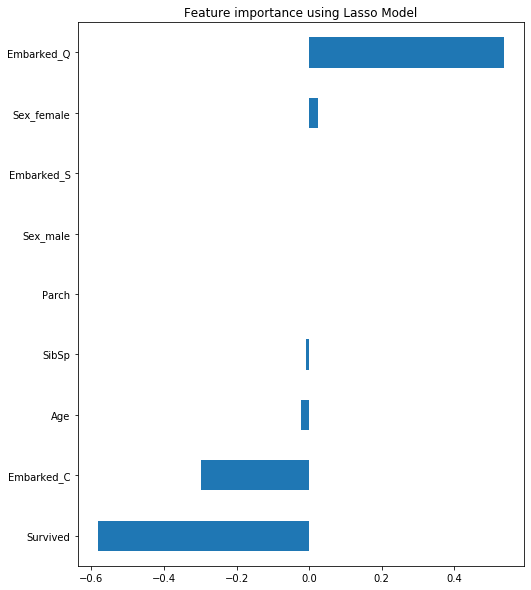

In [68]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

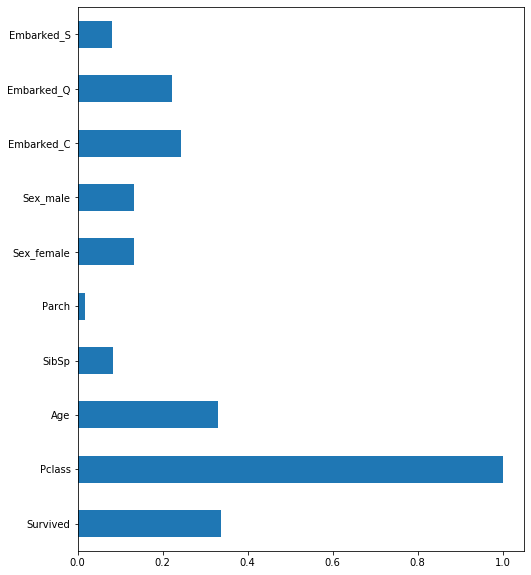

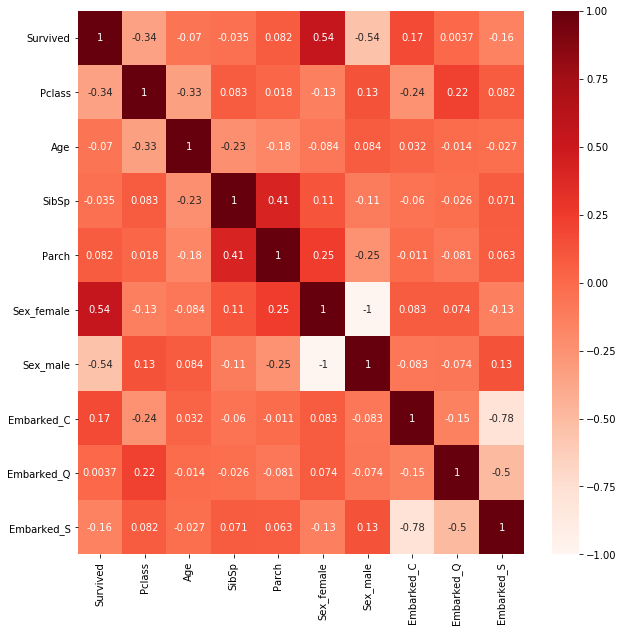

In [69]:
#Using Pearson Correlation
cor = data.corr()
imp_fact = abs(cor[target_column])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_fact.plot(kind = "barh")
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [70]:
#Correlation with output variable
cor_target = abs(cor[target_column])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

Survived      0.338481
Pclass        1.000000
Age           0.331339
Embarked_C    0.243292
Embarked_Q    0.221009
Name: Pclass, dtype: float64

In [71]:
data.to_csv(r'cleaned_train.csv')

In [72]:
from sklearn.linear_model import LogisticRegression


In [73]:
no_uniq = data[target_column].nunique()
# if (no_uniq>2):
#     data[target_column] = pd.cut(data[target_column],len(data),labels=False)
# print("nuniq",data[target_column].nunique())
# print("target_col",data[target_column])

survived_train = data[target_column]
data = data.drop(target_column,axis=1)
train_data,eval_data,labels,eval_labels = train_test_split(data, survived_train, random_state = 0)
# train_data = data.values[:600]
# labels = survived_train[:600]
# eval_data = data.values[600:]
# print(train_data)
# print(labels[0])
# # eval_labels = survived_train[600:]
# print(eval_labels)

In [74]:
if(no_uniq==2):
    model = LogisticRegression(fit_intercept=True)
    model.fit(train_data, labels)
    eval_predictions = model.predict(eval_data)
else:
#     from sklearn.tree import DecisionTreeClassifier 
#     model = DecisionTreeClassifier(max_depth = 3).fit(train_data, labels) 
#     eval_predictions = model.predict(eval_data)
    
    from sklearn.svm import SVC 
    model= SVC(kernel = 'linear', C = 1).fit(train_data, labels) 
    eval_predictions = model.predict(eval_data) 

In [75]:
print('Accuracy of the model on train data: {0}'.format(model.score(train_data, labels)))

Accuracy of the model on train data: 0.6392215568862275


In [76]:
print('Accuracy of the model on eval data: {0}'.format(model.score(eval_data, eval_labels)))

Accuracy of the model on eval data: 0.6771300448430493


In [77]:
data


,Survived,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.000000,1,0,0,1,0,0,1
1,1,38.000000,1,0,1,0,1,0,0
2,1,26.000000,0,0,1,0,0,0,1
3,1,35.000000,1,0,1,0,0,0,1
4,0,35.000000,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,0,1,0,0,1
887,1,19.000000,0,0,1,0,0,0,1
888,0,29.699118,1,2,1,0,0,0,1
889,1,26.000000,0,0,0,1,1,0,0


In [78]:
model.predict([[1,3,1,0,1,0,1,0,0]])

array([2])

In [79]:
print(model.predict([[1,23,2,1,0,0,0,0,1]]))

[1]


In [80]:
print(eval_predictions)

[2 2 2 0 0 0 0 1 0 0 2 0 2 1 0 2 2 2 2 2 2 1 2 2 2 0 2 1 1 2 2 0 2 0 2 0 2
 2 2 0 0 2 2 2 1 2 2 0 2 0 0 0 1 2 0 2 0 2 2 2 2 2 0 2 1 2 0 2 1 1 1 0 2 2
 2 1 2 2 2 2 2 1 2 2 2 1 0 0 1 2 2 2 1 0 2 2 1 2 0 0 2 0 2 2 2 1 1 2 2 2 2
 1 0 2 0 1 1 0 2 0 0 2 2 2 2 0 2 0 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 1 2 2 0
 0 2 2 1 2 2 0 2 0 0 2 2 2 2 0 1 2 2 0 2 2 2 0 0 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 0 2 1 0 2 1 2 0 2 1 2 2 2 2 2 2 0 2 2 2 2 2 1 2 0 2 0
 1]
